# Equations of Motion of Board
## Derive and store the equations of motion of the board

In [1]:
%reset
# DERIVE THE EOMs SYMBOLICALLY ----------------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb,ml1,ml2 = sym.symbols(['m_{body}','m_{leg1}','m_{leg2}']) # mass
lb,ll1,ll2 = sym.symbols(['l_{body}','l_{leg1}','l_{leg2}']) # length
Inb,Inl1,Inl2 = sym.symbols(['I_{body}','I_{leg1}','I_{leg2}']) # moment of intertia

# generalized coordinates
x,y,thb,thl,r = sym.symbols(['x','y','\\theta_{body}','\\theta_{leg}','r']) 
dx,dy,dthb,dthl,dr = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{body}','\dot{\\theta}_{leg}','\dot{r}']) 
ddx,ddy,ddthb,ddthl,ddr = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{body}','\ddot{\\theta}_{leg}','\ddot{r}']) 

q = sym.Matrix([[x],[y],[thb],[thl],[r]])
dq = sym.Matrix([[dx],[dy],[dthb],[dthl],[dr]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb],[ddthl],[ddr]])

# forces
# total joint action = actuator + rebound, but that will be dealt with elsewhere
F,tau,GRFx,GRFy = sym.symbols(['F','\\tau','G_x','G_y']) 

# STEP 1: position vectors ri = [x,y,theta] (world frame)
rb = sym.Matrix([[x],
                [y],
                [thb]])

rl1 = sym.Matrix([[x + 0.5*ll1*sym.sin(thb + thl)],
                [y - 0.5*ll1*sym.cos(thb + thl)],
                [thb + thl]])

rl2 = sym.Matrix([[x + (0.5*ll1+r)*sym.sin(thb + thl)],
                [y - (0.5*ll1+r)*sym.cos(thb + thl)],
                [thb + thl]])

# the Jacobians
Jb = rb.jacobian(q)
Jl1 = rl1.jacobian(q)
Jl2 = rl2.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq
vl1 = Jl1*dq
vl2 = Jl2*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb,Inb]])
Ml1 = sym.Matrix([[ml1,ml1,Inl1]])
Ml2 = sym.Matrix([[ml2,ml2,Inl2]])

T = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) + 0.5*Ml1*sym.matrix_multiply_elementwise(vl1,vl1) + 0.5*Ml2*sym.matrix_multiply_elementwise(vl2,vl2)
T = T[0]
V = mb*g*rb[1] + ml1*g*rl1[1] + ml2*g*rl2[1]


# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces

# force vectors for each link
tau_b = sym.Matrix([[0],[0],[-tau]])
tau_l1 = sym.Matrix([[0],[0],[tau]])

F_l1 = sym.Matrix([[-F*sym.sin(thb+thl)],[F*sym.cos(thb+thl)],[0]])
F_l2 = sym.Matrix([[F*sym.sin(thb+thl)],[-F*sym.cos(thb+thl)],[0]])

GRF_l2 = sym.Matrix([[GRFx],[GRFy],[0.5*ll2*GRFx*sym.cos(thb+thl)+0.5*ll2*GRFy*sym.sin(thb+thl)]])

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = tau_b.transpose()*Jb[:,j]+(tau_l1+F_l1).transpose()*Jl1[:,j]+(F_l2+GRF_l2).transpose()*Jl2[:,j]

# AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


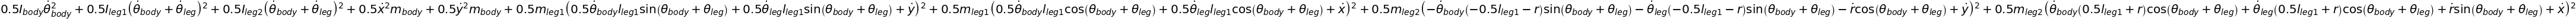

In [2]:
T

In [28]:
# Auxiliary Variables

# system variables
xm,ym,thm,thl,r = sym.symbols(['x_{mono}','y_{mono}','\\theta_{mono}','\\theta_{link1}','r_{mono}']) # monopod in global frame
dxm,dym,dthm,dthl,dr = sym.symbols(['\dot{x}_{mono}','\dot{y}_{mono}','\dot{\\theta}_{mono}','\dot{\\theta}_{link1}','\dot{r}_{mono}'])
l1,l2 = sym.symbols(['l_{link1}','l_{link2}']) # lenghts of links
xb,yb,thb = sym.symbols(['x_{board}','y_{board}','\\theta_{board}']) # board in global frame
dxb,dyb,dthb = sym.symbols(['\dot{x}_{board}','\dot{y}_{board}','\dot{\\theta}_{board}'])

q = sym.Matrix([[xb],[yb],[thb],[xm],[ym],[thm],[thl],[r]])
dq = sym.Matrix([[dxb],[dyb],[dthb],[dxm],[dym],[dthm],[dthl],[dr]])

thA = thm + thl
L = 0.5*l1+0.5*l2+r

pb = sym.Matrix([[xb], [yb]])
pf = sym.Matrix([[xm + L*sym.sin(thA)], [ym - L*sym.cos(thA)]]) # position of foot in global frame

thf = sym.atan((pf[1] - yb)/(pf[0] - xb)) # angle of foot height above horizontal
thbf = thb-thf # absolute angle between board and foot

Rz_thb = sym.Matrix([[sym.cos(thb), sym.sin(thb)], # z-rotation by thb
                     [-sym.sin(thb), sym.cos(thb)]])

pf_b = Rz_thb*(pf-pb) # position of foot in board frame

# Velocity of foot in board frame
vf_b = pf_b.jacobian(q)*dq
vf_bx = vf_b[0].simplify()

In [29]:
var = [xm, ym, thm, thl, r, l1, l2, xb, yb, thb]
var_values = [(xm,2),(ym,2),(thm,0),(thl,0),(r,0),(l1,1),(l2,1),(xb,0),(yb,0),(thb,np.pi/4)]
display(pf.subs(var_values))
display(pf_b.subs(var_values))

⎡ 2 ⎤
⎢   ⎥
⎣1.0⎦

⎡ 2.12132034355964 ⎤
⎢                  ⎥
⎣-0.707106781186547⎦

In [30]:
# Saving equations of motion so you don't have to generate them again
import pickle as pkl

data = {"EOMs":EOMs, "pfoot":pf, "pfoot_board":pf_b, "vfootx_board":vf_bx}

outfile = open('monopod_EOMs','wb')
pkl.dump(data,outfile)
outfile.close()

In [31]:
# UNPICKLE - Test
infile = open('monopod_EOMs','rb')
data = pkl.load(infile)
infile.close()

EOMs = data['EOMs']
pfoot_sb = data['pfoot_board']
pfoot = data['pfoot']
vfootx_sb = data['vfootx_board']

display(EOMs)
display(pfoot)
display(pfoot_sb)
display(vfootx_sb)

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢-0.5⋅Gₓ⋅l_{leg1}⋅cos(\theta_{body} + \theta_{leg}) - 0.5⋅Gₓ⋅l_{leg2}⋅cos(\the
⎢                                                                             
⎢                                                                             
⎢            -0.5⋅Gₓ⋅l_{leg1}⋅cos(\theta_{body} + \theta_{leg}) - 0.5⋅Gₓ⋅l_{le
⎢                                                                             
⎢                                                                             
⎣                                                                             

                                                   

⎡x_{mono} + (0.5⋅l_{link1} + 0.5⋅l_{link2} + r_{mono})⋅sin(\theta_{link1} + \t
⎢                                                                             
⎣y_{mono} - (0.5⋅l_{link1} + 0.5⋅l_{link2} + r_{mono})⋅cos(\theta_{link1} + \t

heta_{mono})⎤
            ⎥
heta_{mono})⎦

⎡(-x_{board} + x_{mono} + (0.5⋅l_{link1} + 0.5⋅l_{link2} + r_{mono})⋅sin(\thet
⎢                                                                             
⎣-(-x_{board} + x_{mono} + (0.5⋅l_{link1} + 0.5⋅l_{link2} + r_{mono})⋅sin(\the

a_{link1} + \theta_{mono}))⋅cos(\theta_{board}) + (-y_{board} + y_{mono} - (0.
                                                                              
ta_{link1} + \theta_{mono}))⋅sin(\theta_{board}) + (-y_{board} + y_{mono} - (0

5⋅l_{link1} + 0.5⋅l_{link2} + r_{mono})⋅cos(\theta_{link1} + \theta_{mono}))⋅s
                                                                              
.5⋅l_{link1} + 0.5⋅l_{link2} + r_{mono})⋅cos(\theta_{link1} + \theta_{mono}))⋅

in(\theta_{board}) ⎤
                   ⎥
cos(\theta_{board})⎦